# Udacity Data Science P2
## Summary
### Dataset
titanic data
### Question
Find out what variables were critical to determine wheter you would survive or not the titanic
### Methodology
I will take a look into the survival rate (#people survived / #total people) grouped by different dimensions available in the dataset

# Data Wrangling
## Import libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## Read the file

In [35]:
data = pd.read_csv('titanic_data.csv', header=0, index_col='PassengerId')

## Take a look on raw values
### Age

In [36]:
# take a look on distribution by age
pd.DataFrame(data.groupby('Age')['Survived'].count())

,Survived
Age,
0.42,1
0.67,1
0.75,2
0.83,2
0.92,1
1.00,7
2.00,10
3.00,6
4.00,10


we can see that the first problem is that there are some values of ages with decimal values, it is easier to work with integers, so that is the first cleaning to do. In general age is not aproximated to the nearest integer, but to the floor integer

In [37]:
# transform all ages to floor integer
data['Age'] = data['Age'].apply(np.floor)

now lets take a look into the missing values

In [38]:
age_missing_values = data['Age'].isnull().sum()
total_records = data['Survived'].count()
proportion_age_missing_values = 1. * age_missing_values / total_records

print 'missing age:', age_missing_values
print 'proportion:', proportion_age_missing_values

missing age: 177
proportion: 0.198653198653


almost 20% of the records is too much, we could fill it in with some average age based in other features. Since I'm going to take a look on it through graphs and the data will be grouped by different attributes, there is no need to drop missing values for now, since they won't appear in the graphs.
### ticket
we have the code of the ticket, maybe we can try to estimate how many people was traveling with the same ticket

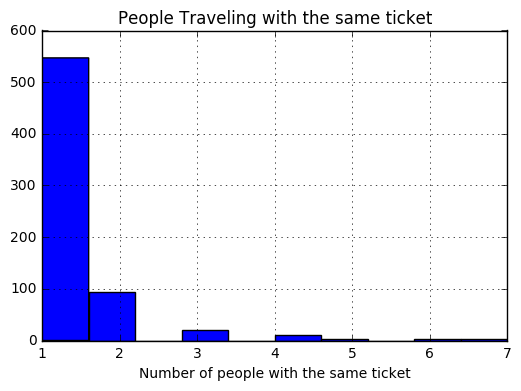

In [58]:
data.groupby('Ticket')['Survived'].count().hist()
plt.title('People Traveling with the same ticket')
plt.xlabel('Number of people with the same ticket')
plt.show()

we can see that most of the people travleed alone, but there is also people in couple and three or four people, we can create a new variable 'travel companions' and see if it has a impact on the survival rate

In [40]:
# count how many people is traveling with the same ticket
data['TravelCompanions'] = data['Ticket'].apply(lambda x:data['Ticket'] == x).sum()
data['TravelCompanions'] = data['TravelCompanions'] - 1

### Cabin Letter
lets take a look

In [41]:
data['Cabin'].dropna()

PassengerId
2              C85
4             C123
7              E46
11              G6
12            C103
22             D56
24              A6
28     C23 C25 C27
32             B78
53             D33
55             B30
56             C52
62             B28
63             C83
67             F33
76           F G73
89     C23 C25 C27
93             E31
97              A5
98         D10 D12
103            D26
111           C110
119        B58 B60
124           E101
125            D26
129          F E69
137            D47
138           C123
140            B86
149             F2
          ...     
752           E121
760            B77
764        B96 B98
766            D11
773            E77
777            F38
780             B3
782            B20
783             D6
790        B82 B84
797            D17
803        B96 B98
807            A36
810             E8
816           B102
821            B69
824           E121
830            B28
836            E49
840            C47
850            C92


we can see that most rows are different, but they have the cabin letter, this might have relation to where people were in the ship at the moment of the sink, and therefore might have an impact on the survival rate. We can create a new variable that holds the most common cabin leter

In [42]:
def max_occurrences(string):
    '''extract the most repeated character in a string'''
    
    # create a default dictionary where the count for each character will be stored
    counter = defaultdict(lambda: 0)
    
    # for every character in the string
    for char in str(string):
        # if the character is a letter
        if char.isalpha():
            # add one to the count
            counter[char] += 1
    
    # get the character with more counts
    return pd.Series(counter).argmax()

# extract the letter of the cabin
data['CabinLetter'] = data['Cabin'][data['Cabin'].notnull()].apply(max_occurrences)

# replace label for people that doesn't have a cabin letter (otherwise graph are not ploted)
data['CabinLetter'].fillna('missing', inplace=True)

### other variables

In [43]:
data.groupby('Survived').count()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TravelCompanions,CabinLetter
Survived,,,,,,,,,,,,
0,549,549,549,424,549,549,549,549,68,549,549,549
1,342,342,342,290,342,342,342,342,136,340,342,342


we can see that the only missing values are in Age, Cabin and a couple in Embarked. Pclass, Survived, Name, Sex, SibSp, Parch, Fare and Embarked seems to have no need to be cleaned.

## Explore the data
### functions to graph data

In [271]:
def filter(df, key_name, value, expression = '=='):
    '''filters a given data frame, given row name and value'''
    quotes = '"' if type(value) == str else ''
    return df[df.eval(key_name + expression + quotes + str(value) + quotes)]

def survival_rate_by(key_name, data=data):
    '''calculate the survival rate for the given rows, if single row is given returns a data serie with the row values as index.
       if multiple rows are given, returns a dictionary with a numpy array for each row value'''
    
    # if survival rate is requested only for one dimension
    if type(key_name) == str:
        # get survivors count by row value
        survivors_count = filter(data, 'Survived', 1).groupby(key_name)['Survived'].count()
        
        # get non survivors for ear row value
        non_survivors_count = filter(data, 'Survived', 0).groupby(key_name)['Survived'].count()
        
        # calculate the survival rate including the values where it is 0
        return survivors_count.div(survivors_count.add(non_survivors_count, fill_value=0), fill_value=0).rename('Survival Rate')
    
    # if multiple dimensions are requested
    elif type(key_name) == list and len(key_name) > 1:
        
        # get the different unique values for the first dimension
        unique_values = data[key_name[0]].unique()
        uniques_dict = {}
        
        # for each dimension, request survival rate
        for value in unique_values:
            # if survival rate is requested for two dimensions
            if len(key_name) == 2:
                # call the function with only one column
                uniques_dict[value] = survival_rate_by(key_name[1], data=filter(data, key_name[0], value))
            
            # if survival rate is requested for more than two dimensions
            else:
                # call the function removing the first element of the list
                uniques_dict[value] = survival_rate_by(key_name[1:], data=filter(data, key_name[0], value))
        
        return uniques_dict
    
def plot_survival_rate_by(key_name, data=data, graph=plt):
    '''plots the survival rate given the column names'''
    
    # if single column is requested
    if type(key_name) == str:
        # calculate the survival rate, mind if we have data that has already filtered
        survival_rate = survival_rate_by(key_name, data=data)
        
        # calculate mortality rate
        mortality_rate = survival_rate - 1
        mortality_rate = mortality_rate.apply(abs)
        
        # get the indexes for the bar graph in case it has text labels
        if survival_rate.index.dtype == object:
            ind = np.arange(len(survival_rate.index))
        else:
            ind = survival_rate.index
        
        # graph survival and morality rate as stacked bars
        graph.bar(ind, survival_rate, color='b', align='center')
        graph.bar(ind, mortality_rate, color='r', bottom=survival_rate, align='center')
        
        # if it is only one graph, show it
        if graph == plt:
            plt.title('Survival rate by ' + key_name)
            plt.xlabel(key_name)
            plt.ylabel('Survival Rate')
            plt.show()
        
        #if not, set this variable in order to put the xticks correctly
        else:
            plt.sca(graph)
        
        # if the data type that is beign graph is not numerical, adjust the labels
        if survival_rate.index.dtype == object:
            plt.xticks(ind, survival_rate.index)
    
    # we are able to graph max three dimensions
    elif type(key_name) == list and 1< len(key_name) <= 3:
        
        # if there are two dimensions
        if len(key_name) == 2:
            # get how many rows it will be
            dimensions = data[key_name[0]].dropna().unique()
            nrows = len(dimensions)
            
            # create the grid
            fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(12, nrows*3))
            
            # for each row, create a graph with the second dimension
            for index, value in enumerate(dimensions):
                
                # filter the data for the current dimension
                filtered_data = filter(data, key_name[0], value)
                
                # plot the single graph
                plot_survival_rate_by(key_name[1], data=filtered_data, graph=axes[index])
            
            # add the rows dimension title
            axes[nrows/2].annotate(key_name[0], (0, 0.5), xytext=(-50, 0),
                                textcoords='offset points', xycoords='axes fraction',
                                ha='right', va='center', size=20, rotation=90)
            
            
            # add the labels for each row
            for ax, dimension in zip(axes, dimensions):
                ax.set_ylabel(dimension, size=18)
            plt.xlabel(key_name[1], size=18)
            fig.suptitle('Survival rate by ' + key_name[0] + ' and ' + key_name[1], size=20)
            
        
        # if there are three dimensions
        else:
            # get number of rows and cols
            h_dimensions = data[key_name[0]].unique()
            v_dimensions = data[key_name[1]].unique()
            
            h_dimensions.sort()
            v_dimensions.sort()
            
            nrows = len(v_dimensions)
            ncols = len(h_dimensions)
            
            # create the grid
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*3))
            
            # for every dimension create the graph
            for c, h_value in enumerate(h_dimensions):
                for r, v_value in enumerate(v_dimensions):
                    
                    # select the grid
                    graph=axes[r][c]
                    
                    # filter the data for the current dimensions
                    filtered_data = filter(filter(data, key_name[0], h_value), key_name[1], v_value)
                    
                    #plot the single graph
                    plot_survival_rate_by(key_name[2], data=filtered_data, graph=graph)
            
            # add the cols dimension title
            axes[0, ncols/2].annotate(key_name[0], (0.5, 1), xytext=(0, 30),
                                textcoords='offset points', xycoords='axes fraction',
                                ha='center', va='bottom', size=20)
            
            # add the labels for each col
            for ax, h_dimension in zip(axes[0], h_dimensions):
                ax.set_title('{0}'.format(h_dimension), size=18)
            
            
            # add the rows dimension title
            axes[nrows/2, 0].annotate(key_name[1], (0, 0.5), xytext=(-50, 0),
                                textcoords='offset points', xycoords='axes fraction',
                                ha='right', va='center', size=20, rotation=90)
            
            
            # add the labels for each row
            for ax, v_dimension in zip(axes[:, 0], v_dimensions):
                ax.set_ylabel(v_dimension, size=18)
                        
        plt.show()                

def describe(key_name):
    #if type(key_name) == str:
        plot_survival_rate_by(key_name)
        sr = survival_rate_by(key_name)
        
        total_people = data.groupby(key_name)['Survived'].count().values
        survivors = data[data['Survived']==1].groupby(key_name)['Survived'].count().values
        
        print str(key_name) + '\tsurvival rate\ttotal people \tsurvivors'
        for index, value in enumerate(sr.values):
            print (str(sr.index.values[index]) +':\t{:2.2f}%\t\t{}\t\t{}').format(value*100, total_people[index], survivors[index])

## Analyze variables indivudually
### Passenger Class

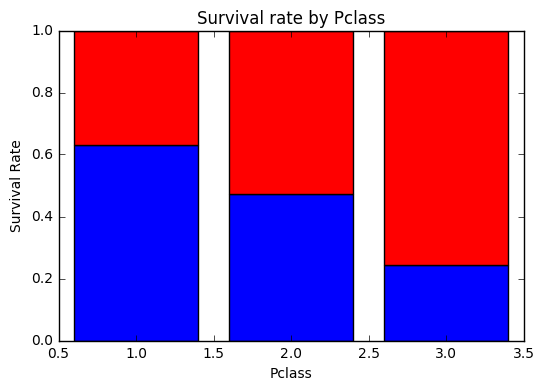

Pclass	survival rate	total people 	survivors
1:	62.96%		216		136
2:	47.28%		184		87
3:	24.24%		491		119


In [45]:
describe('Pclass')

we can see that people in second class have much better chances (almost double) to survie than people in third class, and people in first class has even better chances. 

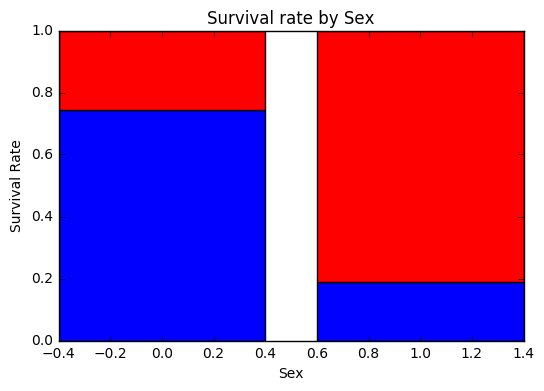

Sex	survival rate	total people 	survivors
female:	74.20%		314		233
male:	18.89%		577		109


In [46]:
describe('Sex')

We can see that female has way better chances to survive than men. This is likely due to the old tradition of saving women and children first.
### Age

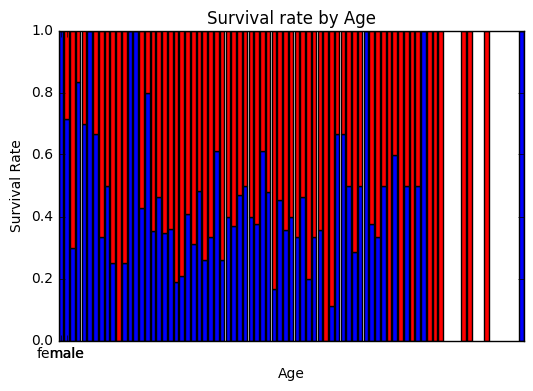

In [47]:
plot_survival_rate_by('Age')

In general, we could say that if you were a child (less than 14 years old), you would have much better chances to survive
### Number of people traveling together

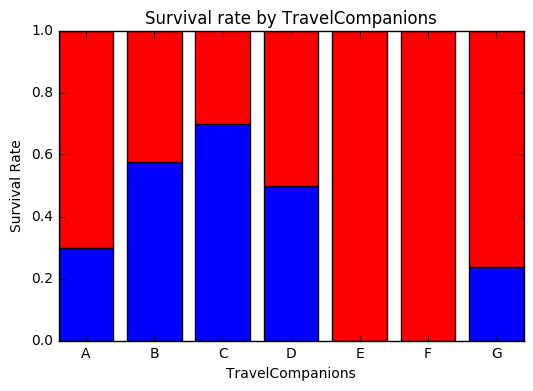

In [100]:
plot_survival_rate_by('TravelCompanions')

We could say that the more people you traveled with, you got better chances to survive, but as long as there where four people in the group.
### Port of departure

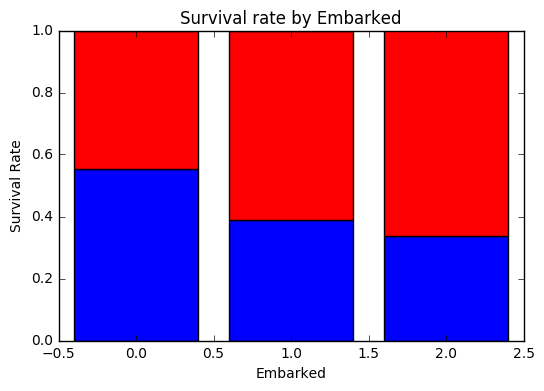

Embarked	survival rate	total people 	survivors
C:	55.36%		168		93
Q:	38.96%		77		30
S:	33.70%		644		217


In [49]:
describe('Embarked')

We can see that people embarked in Cherbourg are more likely to survive than people embarked in other ports, this might be related to other variable, we will further explore interaction among variables.
### Cabin Letter

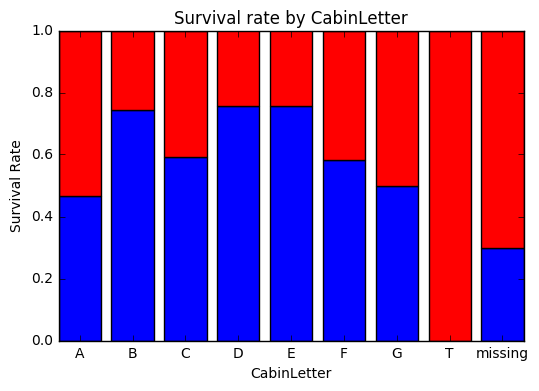

In [99]:
plot_survival_rate_by('CabinLetter')

We can see that there are some cabin letters that have higher survival proportion, this might be due to the location in the ship and the location of safeboats.

## Explore Combinations
### Class and others

We can try to figure out if the higher rate of survival of first class was related to other attributes such age, gender and so on.
### Class and gender

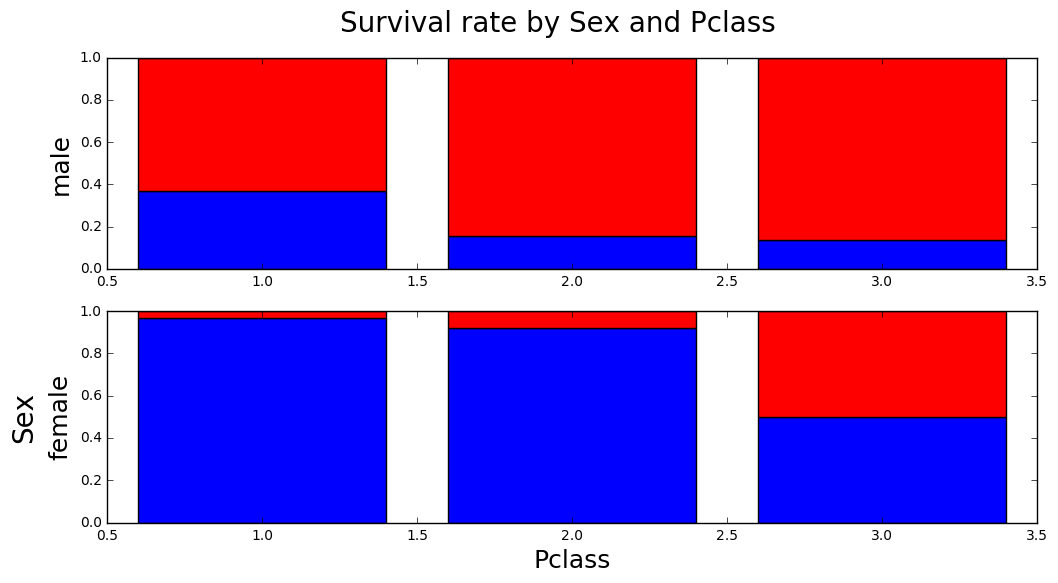

In [272]:
plot_survival_rate_by(['Sex', 'Pclass'])

### Class and cabin letter

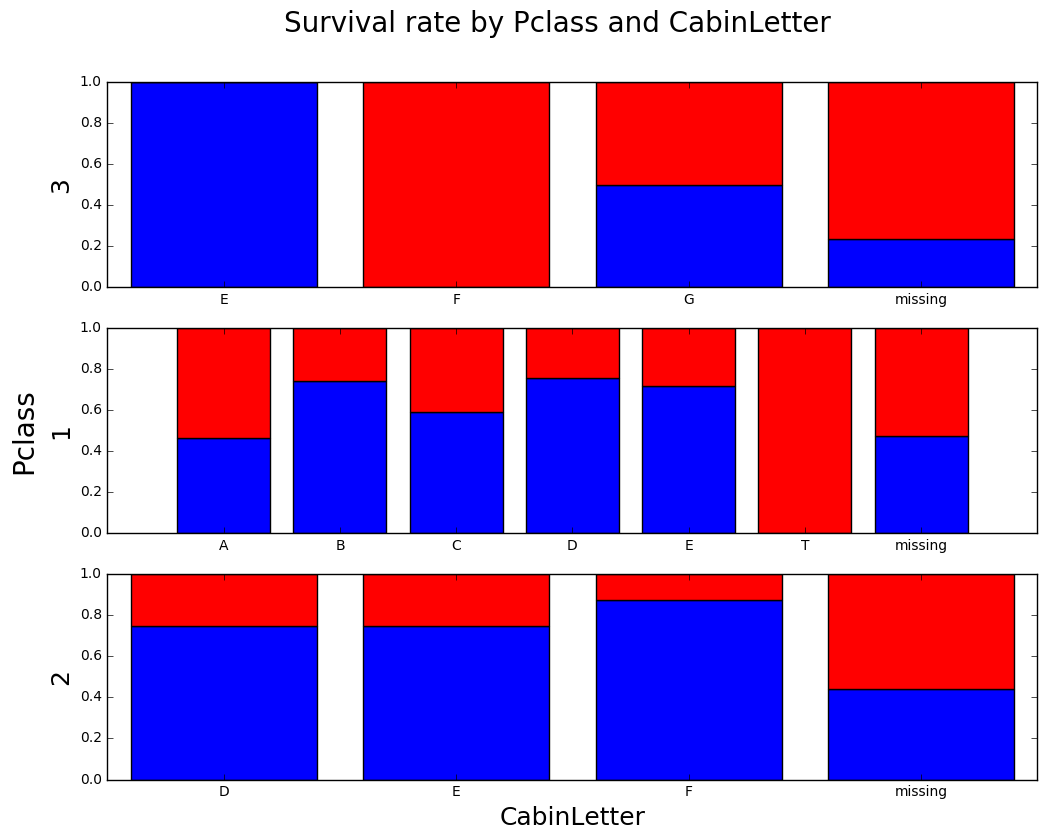

In [273]:
plot_survival_rate_by(['Pclass', 'CabinLetter'])

### Class and port of departure

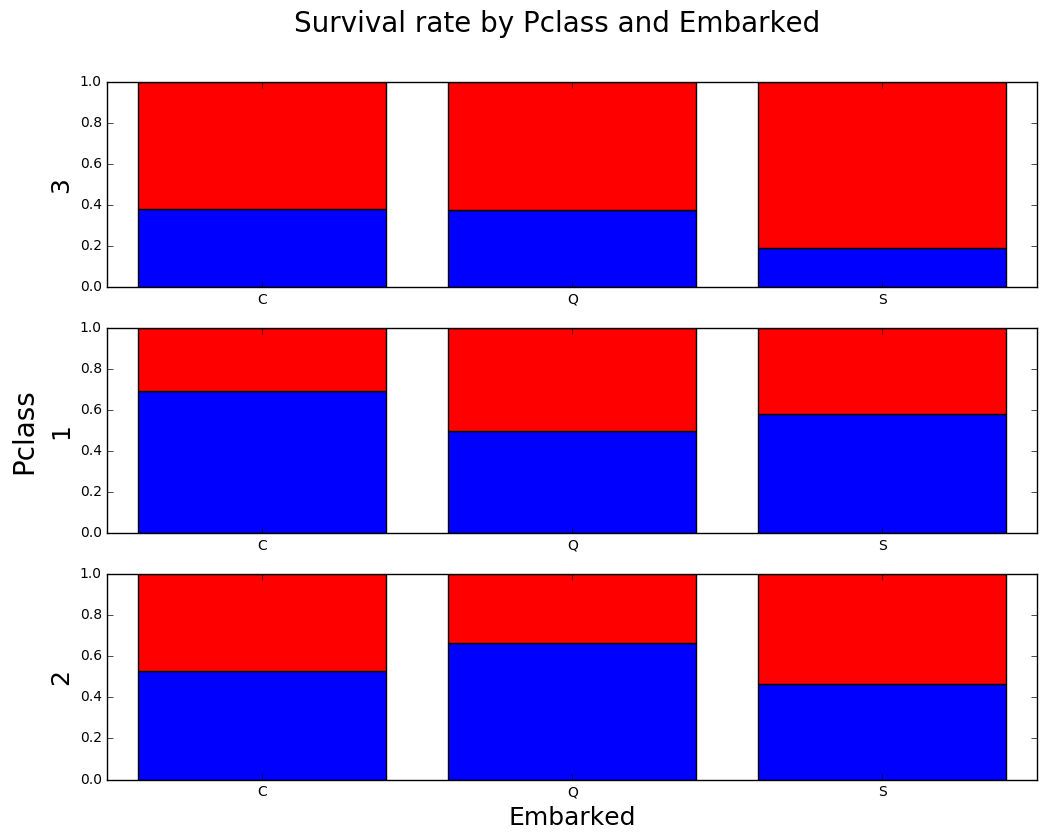

In [274]:
plot_survival_rate_by(['Pclass', 'Embarked'])

### Class and age

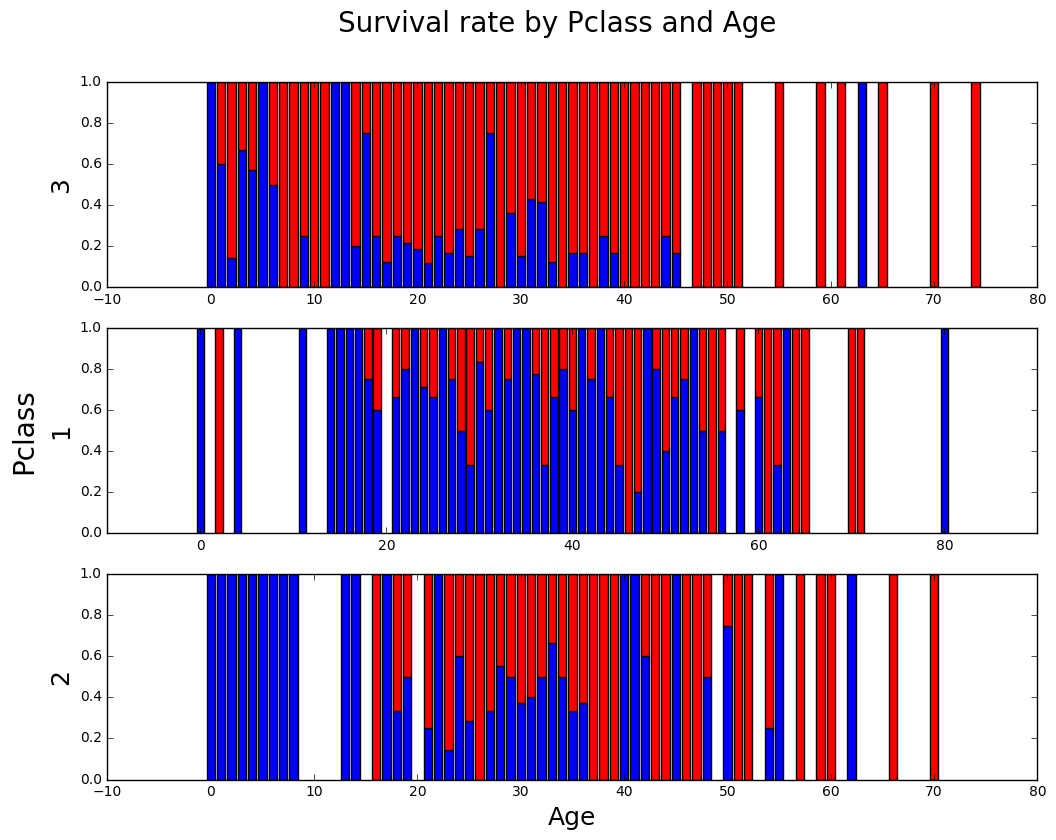

In [275]:
plot_survival_rate_by(['Pclass', 'Age'])

### Class and travel companions

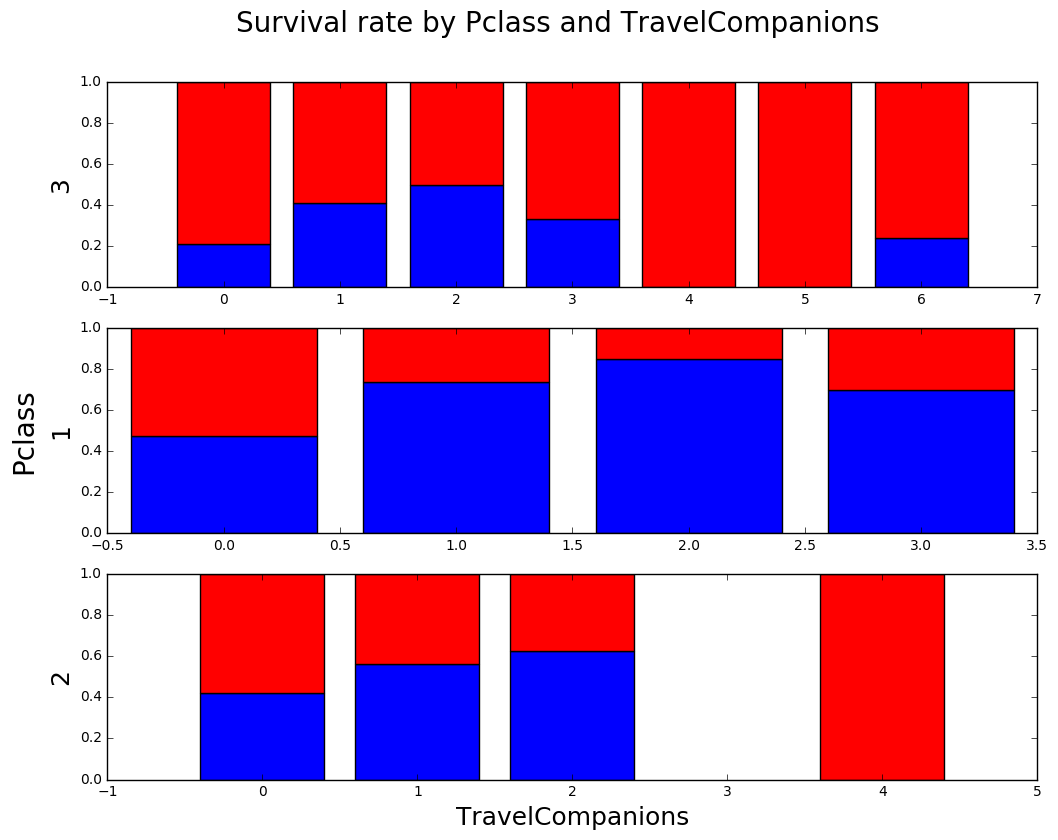

In [276]:
plot_survival_rate_by(['Pclass', 'TravelCompanions'])

We can see that no matter with what variable we combine Class with, with all combinations there is always a higher survival rate for people of first classs, so it should be considered as an important feature. We can also notice that if we combine it with the cabin letter, we get some clusters, probably cause the letter of the cabin was related to the class on which passengers traveled, so we can infere that people likelyhood to survive wasn't only related to the class itself, but also to the place where they were within the ship.

### Gender
We now can take a look at gender
### Gender and Age

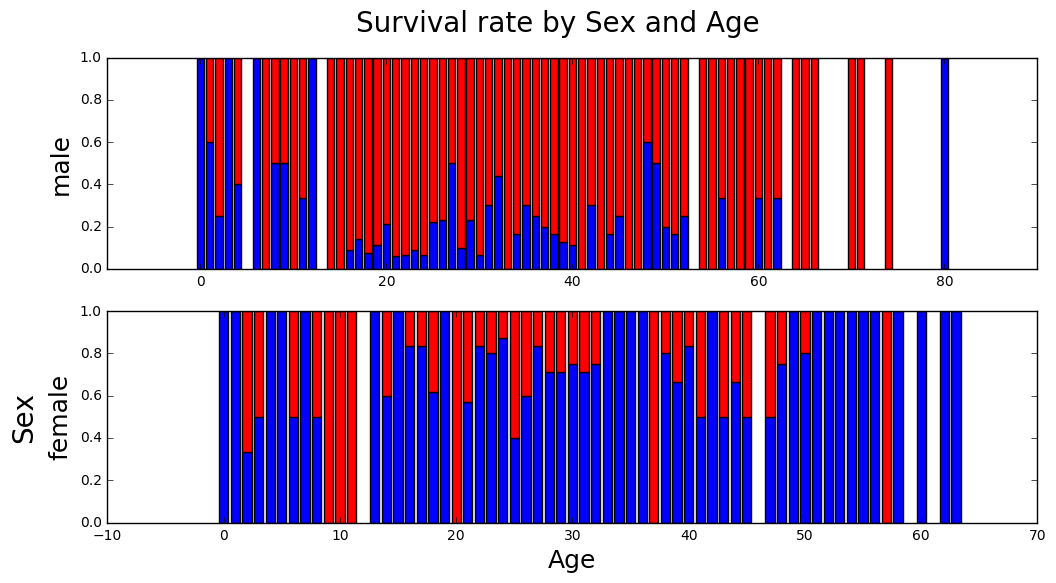

In [277]:
plot_survival_rate_by(['Sex', 'Age'])

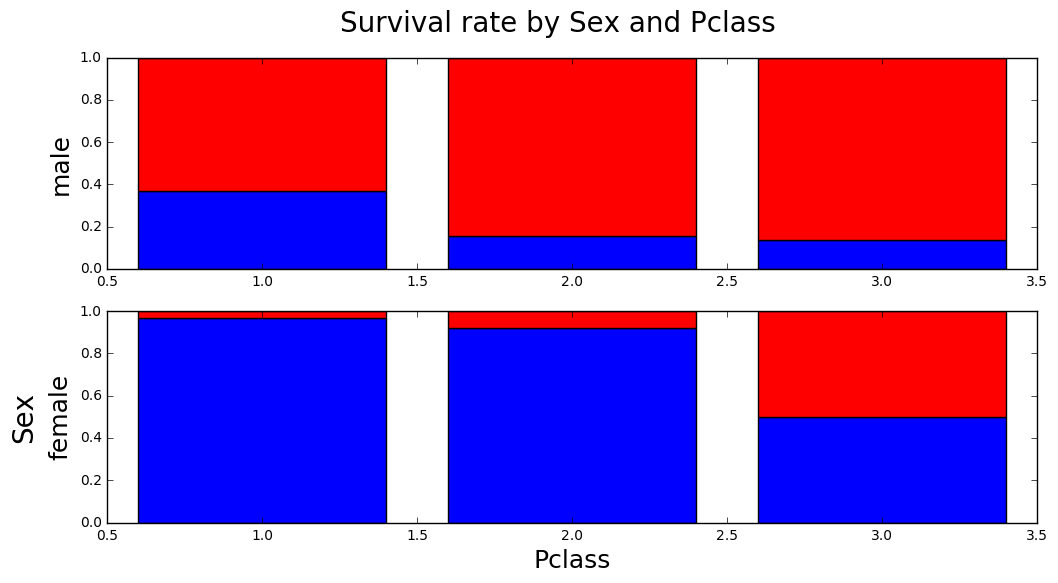

In [278]:
plot_survival_rate_by(['Sex', 'Pclass'])

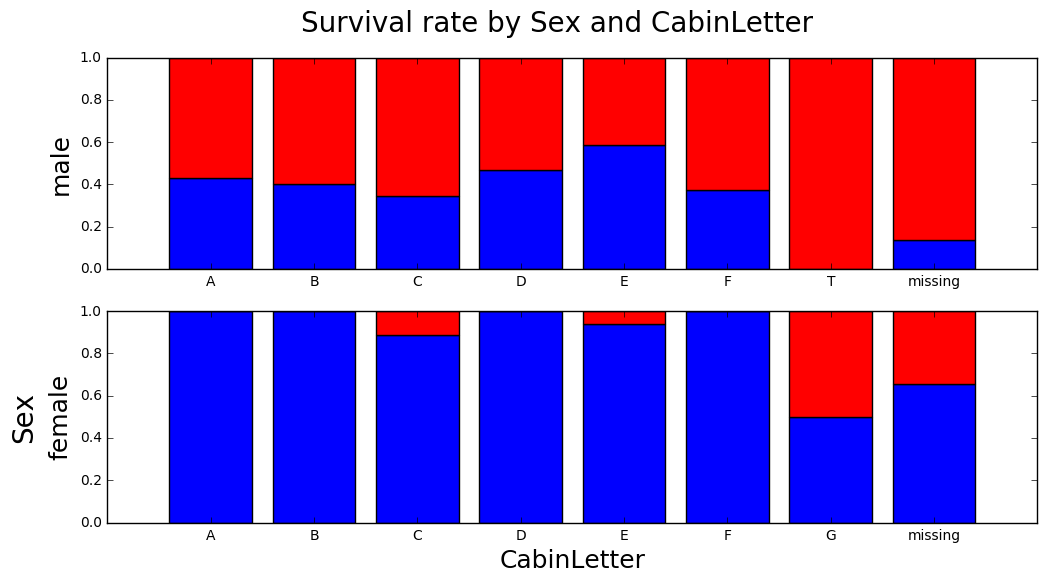

In [280]:
plot_survival_rate_by(['Sex', 'CabinLetter'])

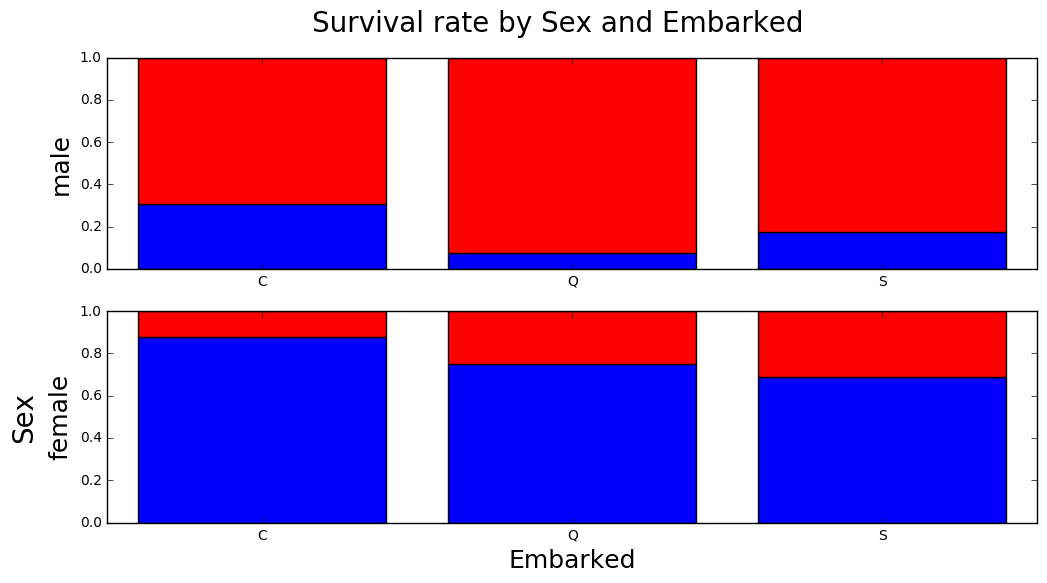

In [281]:
plot_survival_rate_by(['Sex', 'Embarked'])

As with class, we can see that in all interactions, always women have a higher rate of survival, which makes it a very important feature to determine wether somebody survived or not. This makes sense, cause of the code of conduct where women and children lives are saved first.
### Age and other
Now, finally I want to take a look to the different interactions with age

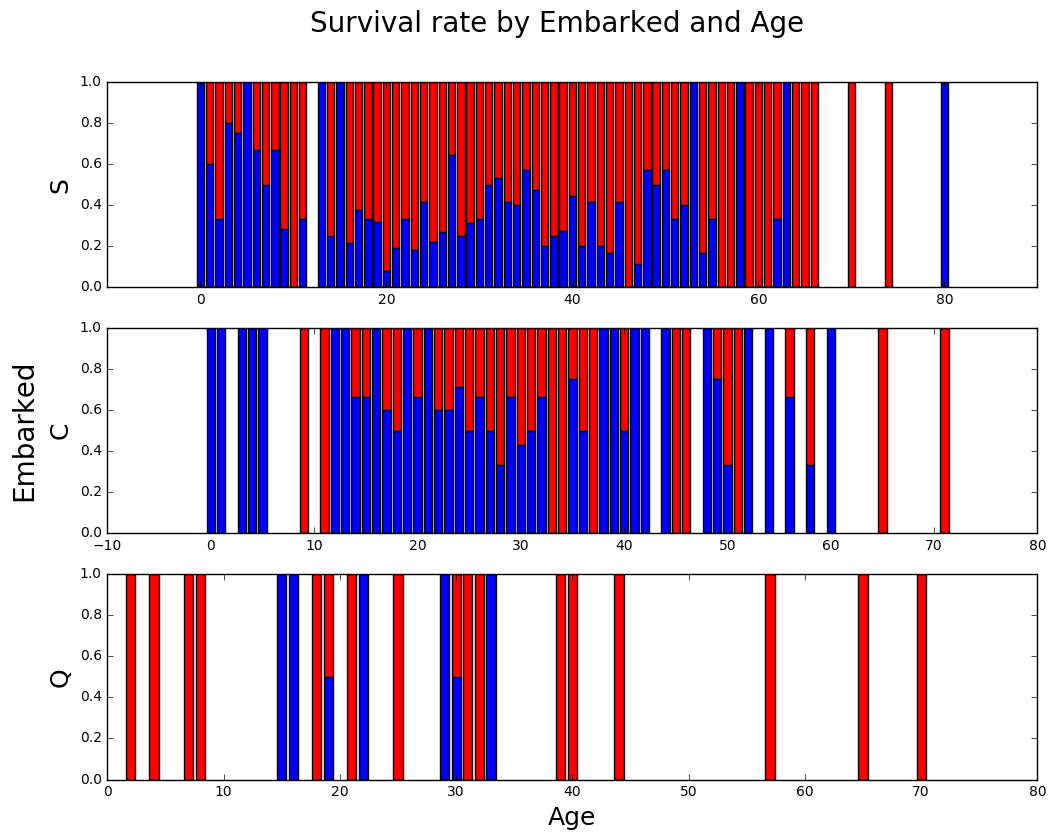

In [282]:
plot_survival_rate_by(['Embarked', 'Age'])

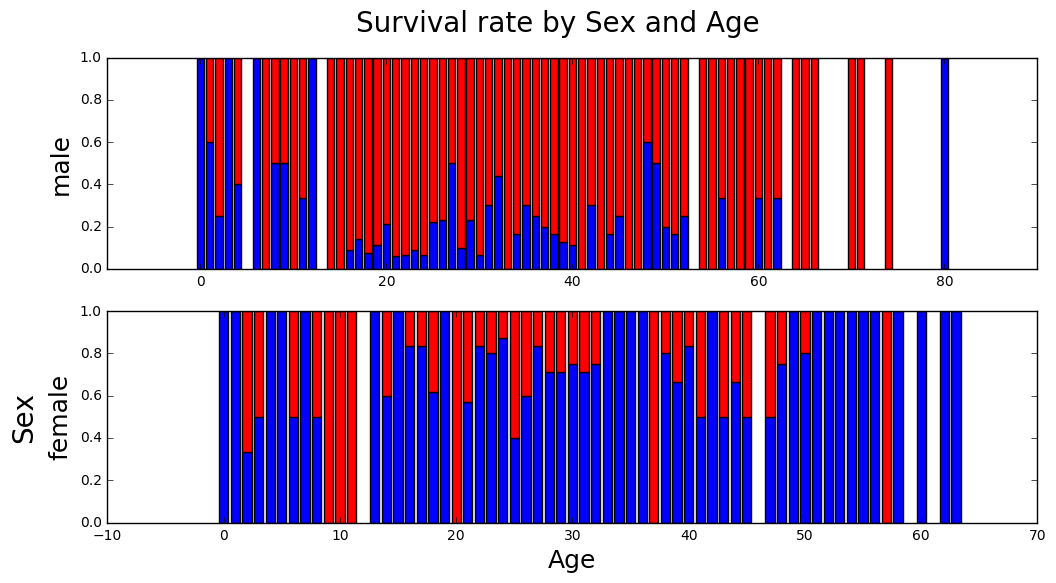

In [283]:
plot_survival_rate_by(['Sex', 'Age'])

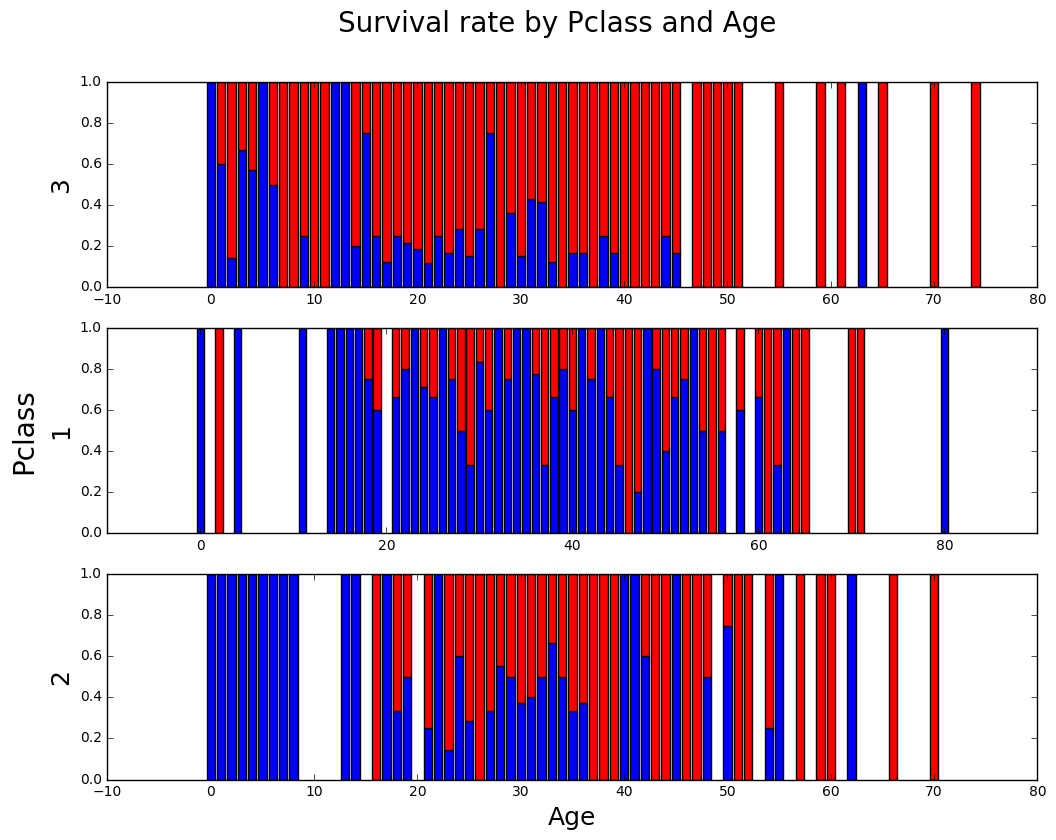

In [284]:
plot_survival_rate_by(['Pclass', 'Age'])

We can see that in ages it varies much more than in gender or class depending on what do we combine it with, so I would say that we have different clusters. In order to identify these clusters we can use the following visualization.

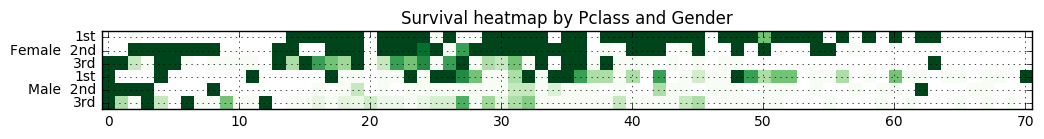

In [285]:
pd_vis = pd.DataFrame(data.groupby(['Pclass','Sex', 'Age'])['Survived'].mean())
raw_vis = pd.pivot_table(pd_vis.reset_index(), values='Survived', index=['Sex', 'Pclass'], columns=['Age']).values

plt.figure(1, figsize=(12,12))
plt.imshow(raw_vis, interpolation='nearest', cmap='Greens')
plt.grid(True)
plt.yticks( [0,1,2,3,4,5], ('1st', 'Female  2nd', '3rd', '1st', 'Male  2nd', '3rd') )

plt.title('Survival heatmap by Pclass and Gender')
plt.show()

In here we ca see that women from 1st and 2nd class of all ages have a good rate of survival, as well as children under 13 years old.

## Conclusion
After looking into the graphs, the dimensions that gives us more relevant information regarding the survival rate of Titanic's passengers are: Age, Gender and Class.

We could say that if you were a kid, regardless of the class you were traveling of, you had good chances of surviving.
If you were a woman traveling in first or second class, you almost certainly would survive.
If you were a woman in third class, or a man in first class, you had some chances to survive.
if you were a man in second or third class, you had alomst no chance to survive.